<a href="https://colab.research.google.com/github/Vladzimir-40/Proj_1/blob/main/my_file4/dz_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub

from google.colab import files
files.upload() # Загрузите файл kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vladimir401011","key":"e6b9eec8a00a0a7c2c3e5fcbd033ab06"}'}

In [3]:

import pandas as pd
import kagglehub
import os

class Data_loading:
    @staticmethod
    def load_from_kaggle(dataset_path, filename, file_type='csv'):
        """
        Загружает dataset из Kaggle используя kagglehub

        Args:
            dataset_path (str): путь к dataset на Kaggle
            filename (str): название файла для загрузки
            file_type (str): тип файла - 'csv' или 'json'

        Returns:
            pd.DataFrame: загруженный датафрейм
        """
        download_path = kagglehub.dataset_download(dataset_path)
        file_path = os.path.join(download_path, filename)

        if file_type == 'csv':
            return pd.read_csv(file_path)
        elif file_type == 'json':
            return pd.read_json(file_path)
        else:
            raise ValueError("Поддерживаются только 'csv' и 'json' форматы")


import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaggle/recipe-ingredients-dataset")

print("Path to dataset files:", path)
print("\nЗагруженные файлы:")
for file in os.listdir(path):
    print(f"📁 {file}")

Using Colab cache for faster access to the 'recipe-ingredients-dataset' dataset.
Path to dataset files: /kaggle/input/recipe-ingredients-dataset

Загруженные файлы:
📁 train.json
📁 test.json


Так мы видим, что данный датасет пердставлен двумя json-файлами.               
"Обучающий" train.json - содердит поле "категирию" (содержит порядка 40000 строк)         
А "Тестовый" test.json - нужен для проверки обученных моделей (содержит порядка 10000)

In [11]:
# Загрузка обучающего датасета
df_train = Data_loading.load_from_kaggle("kaggle/recipe-ingredients-dataset", "train.json", "json")

# Тестовый датасет не подходит
#df_test = Data_loading.load_from_kaggle("kaggle/recipe-ingredients-dataset", "test.json", "json")

Using Colab cache for faster access to the 'recipe-ingredients-dataset' dataset.


In [5]:


# Просматриваем первые несколько строк датасета
print(df_train.head())

# Получаем общую информацию о датасете
print(df_train.info())

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None


Для начала, 40000 строк - это многовато. Для обучения хватит и 3000.

По возможности отберем классы (категории или кухни) пропорционально тому, как они представлены в датасете

In [12]:
# Стратифицированный отбор (сохраняет пропорции классов)
from sklearn.model_selection import train_test_split

# Разделяем исходный датасет на обучающую (3000 строк) и остальную часть
df_limited, df_remaining = train_test_split(df_train, train_size=3000,
                                          stratify=df_train['cuisine'], random_state=42)

# Проверяем: дейстительно 3000 строк
print(df_limited.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 33136 to 23167
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3000 non-null   int64 
 1   cuisine      3000 non-null   object
 2   ingredients  3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.8+ KB
None


Вторая проблема с данными в том, что ингредиенты записаны в матрицы. Мы трижды преобразуем их следующим образом:
1) Перобразуем матрицу в строку
2) Преобзазуем строку в вектор-словарь [значение:вес] (функция "fit")
3) Преобзуем все строки с векторами в одну общую матрицу (функция "transform")

In [7]:
# Преобразуй списки в текст:
df_limited['ingredients_text'] = df_limited['ingredients'].apply(lambda x: ' '.join(x))

# Векторизация: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Указываем оставить только  1000 самых частых ингредиентов (max_features=1000)
# Считается, что редкие ингредиенты мало влияют на классификацию !!!
# Удаляем английские союзы, как возможный шум (stop_words='english')
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(df_limited['ingredients_text'])

# Целевая переменная:
y = df_limited['cuisine']

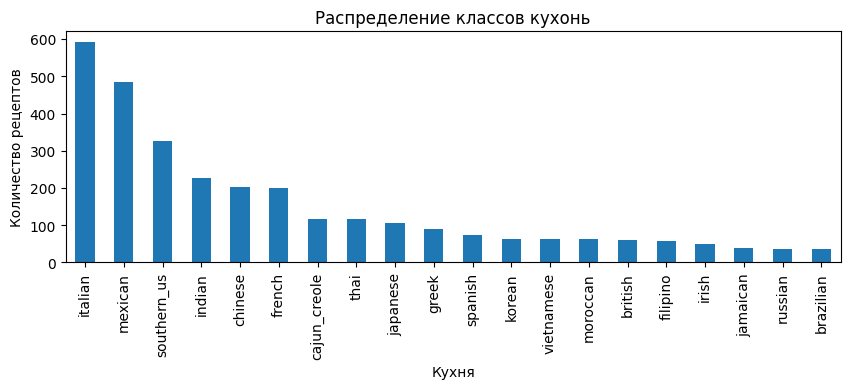

In [8]:
import matplotlib.pyplot as plt

# Статистика по классам
cuisine_counts = df_limited['cuisine'].value_counts()

# График
plt.figure(figsize=(10, 3))
cuisine_counts.plot(kind='bar')
plt.title('Распределение классов кухонь')
plt.xlabel('Кухня')
plt.ylabel('Количество рецептов')
plt.xticks(rotation=90)
plt.show()

Как видим имеется перекос в данных: Итальянская укхня пердставлена почти 600 рецептами, а бразильская - в районе 50 (больше чем 10:1)

Теперь подготовим тестовые данные из оставшейся части

In [14]:
# Преобразуем списки ингредиентов в текст для тестовой выборки
df_remaining['ingredients_text'] = df_remaining['ingredients'].apply(lambda x: ' '.join(x))

# Используем тот же векторизатор для преобразования тестовых данных
X_test = tfidf.transform(df_remaining['ingredients_text'])
y_test = df_remaining['cuisine']

print(f"Размерность тестовых данных: {X_test.shape}")

Размерность тестовых данных: (36774, 1000)


Итог:
  1) Сохраняются пропорции классов в обеих выборках
  2) Тестовая выборка не используется при обучении
  3) Используется один и тот же векторизатор, т.е. будет использована 1000 тех же ингридиентов и в той же последовательности для создания тестовой матрицы ингридиентов X_test
  4) Тестируем на данных, которые модель никогда не видела

Мы имеем многоклассовую классификацию (несколько типов кухонь). Наши данные после преобразования - это разреженная матрица (sparse matrix) с 1000 признаками (ингредиенты) и 3000 образцов.

In [16]:
#!pip install catboost lightgbm scikit-learn pandas numpy matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print(f"Обучающая выборка: {X.shape[0]} рецептов")
#print(f"Тестовая выборка: {X_test.shape[0]} рецептов (используется только для финальной оценки)")

# Словарь для хранения моделей и результатов
models = {}
results = {}

# 1. Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
print("Обучение Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    max_features='sqrt'
)
gb_model.fit(X, y)  # Обучаем на ВСЕЙ обучающей выборке
models['Gradient Boosting'] = gb_model
print("✓ Gradient Boosting обучен")

# 2. Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
print("Обучение Extra Trees...")
et_model = ExtraTreesClassifier(
    random_state=42,
    n_estimators=100,
    max_features='sqrt',
    n_jobs=-1
)
et_model.fit(X, y)  # Обучаем на ВСЕЙ обучающей выборке
models['Extra Trees'] = et_model
print("✓ Extra Trees обучен")

# 3. Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
print("Обучение Decision Tree...")
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=10  # Ограничиваем глубину для предотвращения переобучения
)
dt_model.fit(X, y)  # Обучаем на ВСЕЙ обучающей выборке
models['Decision Tree'] = dt_model
print("✓ Decision Tree обучен")

# 4. Попробуем CatBoost (если установлен)
try:
    from catboost import CatBoostClassifier
    print("Обучение CatBoost...")
    catboost_model = CatBoostClassifier(
        random_state=42,
        verbose=False,
        learning_rate=0.1,
        depth=6,
        iterations=300  # Уменьшили для скорости (на 300 - 5 мин)
    )
    catboost_model.fit(X, y)  # Обучаем на ВСЕЙ обучающей выборке
    models['CatBoost'] = catboost_model
    print("✓ CatBoost обучен")
except ImportError:
    print("✗ CatBoost не установлен, пропускаем")

# 5. Попробуем LightGBM (если установлен)
try:
    from lightgbm import LGBMClassifier
    print("Обучение LightGBM...")
    lgbm_model = LGBMClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        n_jobs=-1,
        verbose=-1
    )
    lgbm_model.fit(X, y)  # Обучаем на ВСЕЙ обучающей выборке
    models['LightGBM'] = lgbm_model
    print("✓ LightGBM обучен")
except ImportError:
    print("✗ LightGBM не установлен, пропускаем")

print(f"\nОбучено моделей: {len(models)}")

Обучающая выборка: 3000 рецептов
Обучение Gradient Boosting...
✓ Gradient Boosting обучен
Обучение Extra Trees...
✓ Extra Trees обучен
Обучение Decision Tree...
✓ Decision Tree обучен
Обучение CatBoost...
✓ CatBoost обучен
Обучение LightGBM...
✓ LightGBM обучен

Обучено моделей: 5


Попробуем взять Бустовые модели и Деревянных три на две

Бустовые:
  * CatBoost
  * Классификатор градиентного бустинга
  * Light Gradient Boosting Machine

Деревянные:
  * Классификатор Extra Trees
  * Классификатор дерева решений

In [22]:
# Оценка на тестовых данных
print("\n=== ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ ===")
#results = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name}: {accuracy:.4f}")

# Детальный отчет по лучшей модели
print(f"\nДетальный отчет для {best_model_name}:")
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


=== ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ ===
Gradient Boosting: 0.6257
Extra Trees: 0.6814
Decision Tree: 0.4666
CatBoost: 0.6571
LightGBM: 0.6556

Детальный отчет для Extra Trees:
              precision    recall  f1-score   support

   brazilian       0.73      0.24      0.36       432
     british       0.47      0.13      0.20       743
cajun_creole       0.76      0.60      0.67      1429
     chinese       0.65      0.85      0.74      2471
    filipino       0.70      0.30      0.42       698
      french       0.47      0.39      0.42      2447
       greek       0.82      0.47      0.60      1086
      indian       0.77      0.88      0.82      2777
       irish       0.65      0.17      0.27       617
     italian       0.63      0.89      0.74      7247
    jamaican       0.94      0.34      0.50       486
    japanese       0.74      0.55      0.63      1316
      korean       0.88      0.42      0.56       767
     mexican       0.79      0.92      0.85      5953
    moroccan      

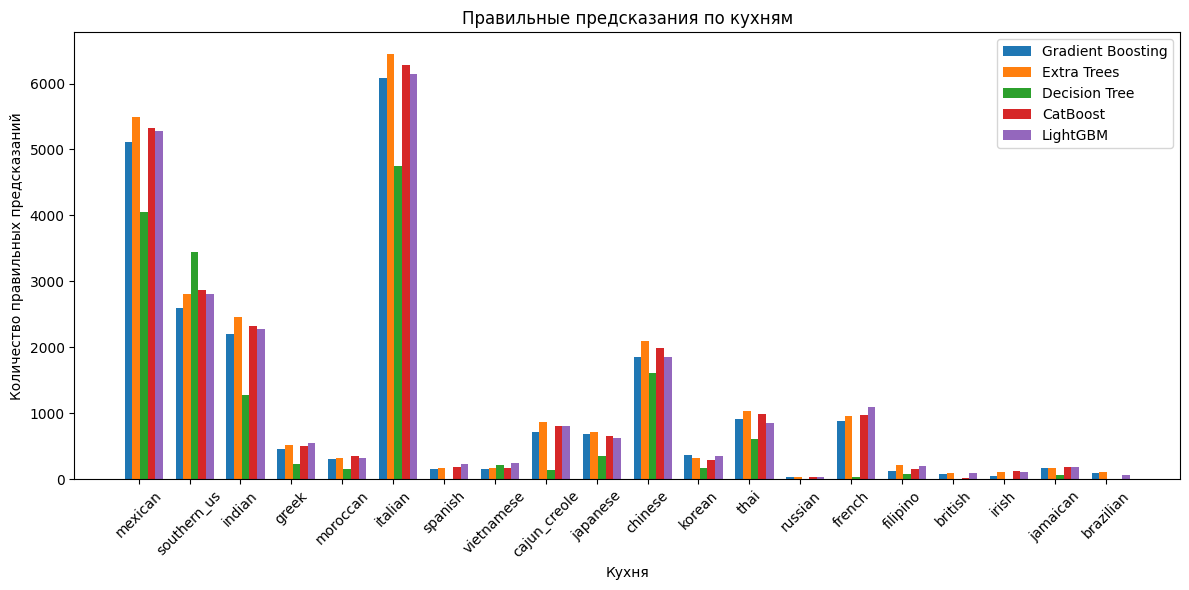

In [19]:
import matplotlib.pyplot as plt

# Создаем график
plt.figure(figsize=(12, 6))

# Для каждой модели строим столбцы правильных предсказаний
for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    if y_pred.ndim > 1: y_pred = y_pred.ravel()
    correct_by_cuisine = [(y_test == y_pred)[y_test == cuisine].sum() for cuisine in y_test.unique()]
    plt.bar(np.arange(len(y_test.unique())) + i*0.15, correct_by_cuisine, width=0.15, label=model_name)

plt.title('Правильные предсказания по кухням')
plt.ylabel('Количество правильных предсказаний')
plt.xlabel('Кухня')
plt.xticks(np.arange(len(y_test.unique())) + 0.2, y_test.unique(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

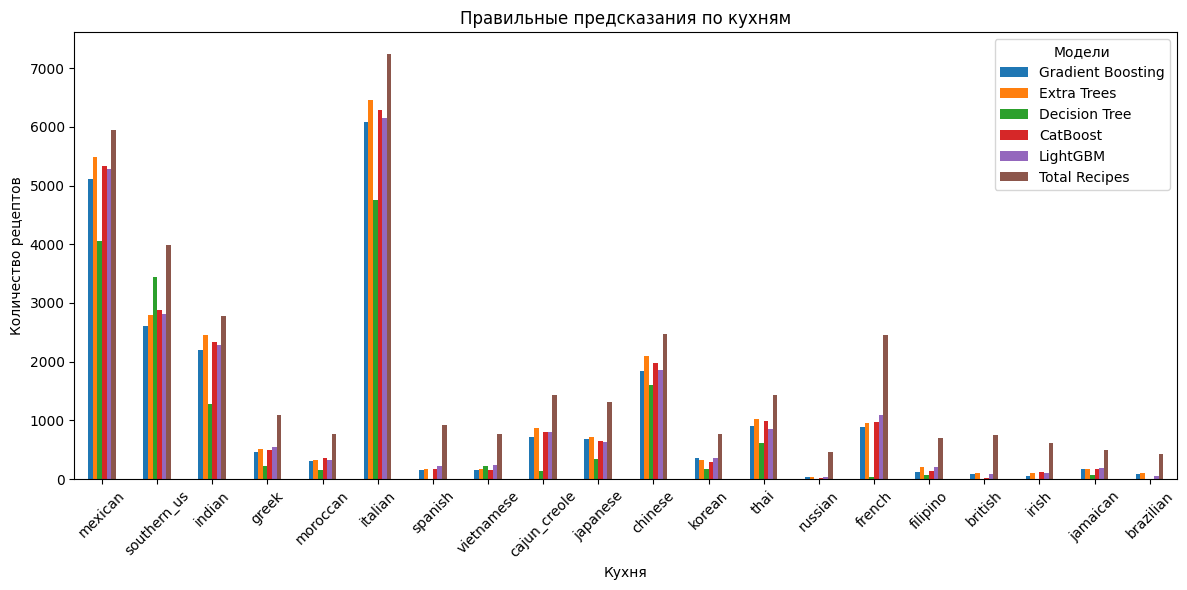

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Создаем DataFrame для визуализации
results_comparison = pd.DataFrame(index=y_test.unique())

# Собираем правильные предсказания для каждой модели
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    if y_pred.ndim > 1:
        y_pred = y_pred.ravel()
    correct_predictions = (y_test == y_pred)
    results_comparison[model_name] = [correct_predictions[y_test == cuisine].sum() for cuisine in results_comparison.index]

# Добавляем общее количество рецептов по кухням
results_comparison['Total Recipes'] = y_test.value_counts()

# Строим график
plt.figure(figsize=(12, 6))
results_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Правильные предсказания по кухням')
plt.ylabel('Количество рецептов')
plt.xlabel('Кухня')
plt.xticks(rotation=45)
plt.legend(title='Модели')
plt.tight_layout()
plt.show()

Итог: С перекосом данных в датасете лучше всех справился Extra Trees: 0.6814, а хуже всех Decision Tree: 0.4666